In [1]:
# DS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

from my_utils import *

In [2]:
pd.options.mode.chained_assignment = None  # default='warn' # disable chain assignment warnings

p_data = "data"

print(VERSION)

v3.0


# POI2Vec

In [3]:
gdf_zoning = read_csv_to_gdf(f"result/gdf_zoning_{VERSION}.csv").to_crs("epsg:2263")
gdf_poi = gpd.GeoDataFrame(pd.read_pickle(f"result/gdf_poi_{VERSION}.pkl"),crs="epsg:4326",geometry="geometry").to_crs("epsg:2263")

##  generate sequences

In [6]:
gdf_zoning

,ZONEDIST,Shape_Leng,Shape_Area,geometry,zone_c
0,R5,1862.207446,1.943711e+05,"POLYGON ((960088.755 175295.955, 960167.942 17...",RL
1,R5,19208.305164,2.767667e+06,"POLYGON ((960059.292 174171.108, 960059.475 17...",RL
2,R6,2935.376415,5.333286e+05,"POLYGON ((961651.706 174650.645, 961660.812 17...",RH
3,R4,3246.982638,5.797014e+05,"POLYGON ((961651.706 174650.645, 961674.810 17...",RL
4,M1-1,1797.546542,1.966755e+05,"POLYGON ((960152.794 174247.268, 960059.475 17...",MU
...,...,...,...,...,...
5465,PARK,89.886438,2.464241e+01,"POLYGON ((1004519.280 252141.155, 1004522.409 ...",PU
5466,PARK,90.809731,2.530755e+01,"POLYGON ((1004553.272 252204.641, 1004558.730 ...",PU
5467,PARK,319.401729,3.051550e+01,"POLYGON ((1004606.624 252259.543, 1004616.892 ...",PU
5468,PARK,426.120847,6.939689e+01,"POLYGON ((1004464.949 251935.144, 1004475.689 ...",PU


In [7]:
gdf_zoningm.to_file("demo.shp")

In [317]:
import tqdm
from shapely.geometry import Polygon
from geopandas.tools import sjoin 

def get_sequences_by_distancegreedy(gdf_tz, gdf_poi):
    sequences={}
    gdf_tz["geometry"] =  gdf_tz.apply(lambda x:Polygon(x["geometry"].buffer(100).exterior), axis=1)
    df_join = sjoin(gdf_poi, gdf_tz, how="inner",op="within")
    
    for tz_ind in tqdm.tqdm(df_join.index_right.unique()):
        tz_pois = df_join[df_join.index_right==tz_ind].reset_index()
#     for tz_ind in tqdm.tqdm(range(len(gdf_tz))):
        
#         tz = gdf_tz.iloc[tz_ind,:].geometry
#         tz_pois = gdf_poi[gdf_poi.within(tz)].reset_index()
        #print(len(tz_pois))
        if tz_pois.shape[0]>0:
            ## create distance matrix for each two points
            pnt_num = tz_pois.shape[0]
            dismat = np.zeros(shape=(pnt_num,pnt_num),dtype=int)
            for i in range(pnt_num):
                for j in range(pnt_num):
                    dismat[i,j] = int(tz_pois.loc[i,"geometry"].distance(tz_pois.loc[j,"geometry"]))

            ## get the pair with largest distance
            visited = list(np.unravel_index(np.argmax(dismat, axis=None), dismat.shape))
            
            ## list of to be visited points
            not_visited = [x for x in range(pnt_num) if x not in visited]

            np.random.shuffle(not_visited)

            while not_visited:
                to_be_visit = not_visited.pop()
                if len(visited)==2:
                    visited.insert(1,to_be_visit)
                    pass
                else:
                    ## find the index to insert
                    search_bound = list(zip(visited[0:-1],visited[1:]))
                    dis = [dismat[to_be_visit,x]+dismat[to_be_visit,y] for x,y in search_bound]
                    insert_place = dis.index(min(dis))+1

                    visited.insert(insert_place,to_be_visit)
            sequences[tz_ind] = tz_pois.loc[visited,"code"].values
            # yield sequences
    return sequences

### Option 1. Distance Greedy 

In [11]:
from shapely.geometry import Polygon
from geopandas.tools import sjoin

gdf_zoning["geometry"] =  gdf_zoning.apply(lambda x:Polygon(x["geometry"].buffer(100).exterior), axis=1)
df_join = sjoin(gdf_poi, gdf_zoning, how="inner",op="within")

In [13]:
gdf_zoning

,ZONEDIST,Shape_Leng,Shape_Area,geometry,zone_c
0,R5,1862.207446,1.943711e+05,"POLYGON ((959934.924 175168.142, 959931.848 17...",RL
1,R5,19208.305164,2.767667e+06,"POLYGON ((959597.010 171677.460, 959586.798 17...",RL
2,R6,2935.376415,5.333286e+05,"POLYGON ((961567.908 174469.047, 961563.544 17...",RH
3,R4,3246.982638,5.797014e+05,"POLYGON ((961735.613 174832.193, 961758.609 17...",RL
4,M1-1,1797.546542,1.966755e+05,"POLYGON ((960279.655 174092.652, 960186.272 17...",MU
...,...,...,...,...,...
5465,PARK,89.886438,2.464241e+01,"POLYGON ((1004700.203 252055.907, 1004697.980 ...",PU
5466,PARK,90.809731,2.530755e+01,"POLYGON ((1004704.604 252073.879, 1004701.271 ...",PU
5467,PARK,319.401729,3.051550e+01,"POLYGON ((1004728.279 252100.798, 1004724.348 ...",PU
5468,PARK,426.120847,6.939689e+01,"POLYGON ((1004658.337 251884.142, 1004656.970 ...",PU


<AxesSubplot:>

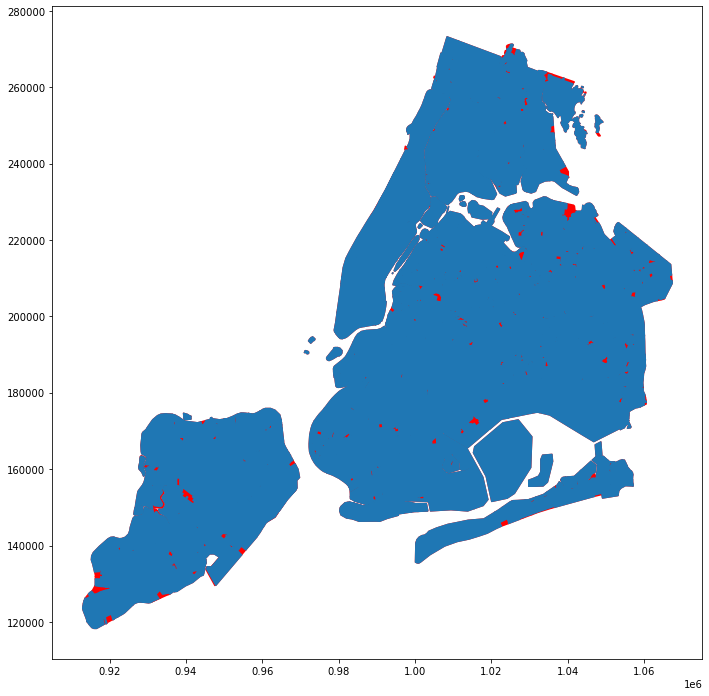

In [12]:
ax = gdf_zoning.plot(figsize=(12,12),facecolor="r")
gdf_zoning.loc[list(df_join.index_right.unique())].plot(ax=ax)

In [332]:
sequences = get_sequences_by_distancegreedy(gdf_zoningm, gdf_poi)

  1%|▍                                                                            | 10/1843 [04:17<13:07:48, 25.79s/it]


KeyboardInterrupt: 

In [257]:
sequences

{}

In [ ]:
gdf_tz["geometry"] =  gdf_tz["geometry"].apply(lambda x:Polygon(x.buffer(10).exterior))
df_join = sjoin(gdf_poi, gdf_tz, how="inner",op="within")

In [ ]:
np.save(f"result/Sequences_greedy_{VERSION}.npy", sequences)

In [168]:
sequences

{}

In [161]:
len(sequences.keys()),len(gdf_zoningm)

(0, 2732)

##